# "Parts of form" explorer

developed by Kow Kuroda (kow.kuroda@gmail.com)

History

Created 2024/09/13

Modified 2025/08/01 i) added handling of Englsh WN3 word classification; ii) added gender sub-classification for Irish;

In [328]:
#!pip install -U pyLDAvis
#!pip install -U pandas

In [329]:
## imports
import os, sys
import pprint as pp
import unicodedata

In [330]:
## 一つ上の階層のファイルを見るように設定
sys.path.append(os.path.join(os.path.dirname("__file__"), '..'))

In [331]:
## Cython module の生成 (必要に応じて)
#!python clean setup.py build_ext --inplace

In [332]:
## Cython を使うかどうか
use_Cython = False
if use_Cython:
    %load_ext Cython

In [333]:
## doc settings
doc_types        = [ 'spell', 'sound' ]
doc_type          = doc_types[0]
print(f"doc_type: {doc_type}")

### boundary handling
mark_boundaries     = True
boundary_mark       = "#"
print(f"mark_boundaries with {boundary_mark}: {doc_type}")

## sizes
max_doc_size        = 11
min_doc_size        =  5
print(f"max_doc_size: {max_doc_size}")
print(f"min_doc_size: {min_doc_size}")

doc_type: spell
mark_boundaries with #: spell
max_doc_size: 11
min_doc_size: 5


In [334]:
## term settings
ngram_is_inclusive  = True
inclusion_degree    = None # or 1 # smaller values give better results

## term setting
#ngram_is_skippy       = False
skippy_means_extended = False

gap_mark            = "…"
seg_joint           = ""

### accent handling
suppress_accents    = True
accent_marks        = [ "ˈ", "ˌ" ] 
if doc_type == 'sound':
    if suppress_accents:
        accent_status = "-unaccented"
    else:
        accent_stratus = "-accented"
else:
    accent_status = ""
print(f"accent_status: {accent_status}")

accent_status: 


In [335]:
## select target files
import glob
data_dir1      = "data/open-dict-ipa/data1"
data_dir2      = "data/open-dict-ipa/data1a"
data_dir3      = "data/wn3"
data_dir4      = "data/irish"
target_files   = glob.glob(f"{data_dir1}/*")
target_files2  = glob.glob(f"{data_dir2}/*")
target_files.extend(target_files2)
target_files3  = glob.glob(f"{data_dir3}/*")
target_files.extend(target_files3)
target_files4  = glob.glob(f"{data_dir4}/*")
target_files.extend(target_files4)
pp.pprint(target_files)

['data/open-dict-ipa/data1/yue.csv.gz',
 'data/open-dict-ipa/data1/vi_S.csv.gz',
 'data/open-dict-ipa/data1/de.csv.gz',
 'data/open-dict-ipa/data1/jam.csv.gz',
 'data/open-dict-ipa/data1/ro.csv.gz',
 'data/open-dict-ipa/data1/fa.csv.gz',
 'data/open-dict-ipa/data1/zh_hant.csv.gz',
 'data/open-dict-ipa/data1/sw.csv.gz',
 'data/open-dict-ipa/data1/ar.csv.gz',
 'data/open-dict-ipa/data1/es_MX.csv.gz',
 'data/open-dict-ipa/data1/vi_C.csv.gz',
 'data/open-dict-ipa/data1/ma.csv.gz',
 'data/open-dict-ipa/data1/en_US.csv',
 'data/open-dict-ipa/data1/fi.csv.gz',
 'data/open-dict-ipa/data1/eo.csv.gz',
 'data/open-dict-ipa/data1/fr_QC.csv.gz',
 'data/open-dict-ipa/data1/es_ES.csv.gz',
 'data/open-dict-ipa/data1/en_US.csv.gz',
 'data/open-dict-ipa/data1/en_UK.csv.gz',
 'data/open-dict-ipa/data1/nb.csv.gz',
 'data/open-dict-ipa/data1/nl.csv.gz',
 'data/open-dict-ipa/data1/sv.csv.gz',
 'data/open-dict-ipa/data1/or.csv.gz',
 'data/open-dict-ipa/data1/zh_hans.csv.gz',
 'data/open-dict-ipa/data1/fr_FR.

In [336]:
## a key must be part of a file name 
target_lang_dict = {    'en_US' : 'English (US)',
                        'en_UK' : 'English (UK)',
                        'en_N_only' : 'English noun (WN)',
                        'en_V_only' : 'English verb (WN)',
                        'en_A_only' : 'English adj (WN)',
                        'en_R_only' : 'English adv (WN)',
                        'ar'    : 'Arabic',
                        'de'    : 'German',
                        'de_N_only' : 'German noun',
                        'de_non_N_only' : 'German non-noun',
                        'eo'    : 'Esperanto',
                        'es_ES' : 'Spanish (Spain)',
                        'es_MX' : 'Spanish (Mexico)',
                        'fi'    : 'Finnish',
                        'fr_FR' : 'French (France)',
                        'fr_QC' : 'French (Quebec)',
                        'is'    : 'Icelandic',
                        'ir'    : 'Irish',
                        'nl'    : 'Dutch',
                        'ro'    : 'Romanian',
                        'sw'    : 'Swahili' }
## proper language selection
target_lang_keys = [    'en_US', # 0
                        'en_UK', # 1
                        'en_N_only', # 2
                        'en_V_only', # 3
                        'en_A_only', # 4
                        'en_R_only', # 5
                        'ar', # 6
                        'de', # 7
                        'de_N_only', # 8
                        'de_non_N_only', # 9
                        'eo', 'es_ES', 'es_MX',
                        'fi', 'fr_FR', 'fr_QC',
                        'is', 'nl', 'ro', 'sw',
                        'ir' # This lacks sound
                    ]

In [337]:
## select language
target_lang_key  = target_lang_keys[0]
print(f"target_lang_key: {target_lang_key}")
target_lang_name = target_lang_dict[target_lang_key]
print(f"target lang: {target_lang_name} [{target_lang_key}]")

target_lang_key: en_US
target lang: English (US) [en_US]


In [ ]:
## select word class
selects_word_class = True

# R_only is not available for Irish, non_N_only for German;
target_word_classes = [ 'N_only', 'non_N_only', 'A_only', 'R_only', 'V_only' ]
if not selects_word_class:
    target_word_class = None
else:
    #target_word_class = target_word_classes[0:1] + target_word_classes[-1:]
    target_word_class = target_word_classes[-2]
print(f"target_word_class: {target_word_class}")
#
target_files_base = target_files.copy() # make a reserve
#
if selects_word_class:
    lang_key = target_lang_key.split("_")[0]
    print(f"lang_key: {lang_key}")
    print(f"target_word_class: {target_word_class}")
    if not target_word_class != 'non_N_only':
        target_files = [ f for f in target_files_base if not f"non_{target_word_class}" in f ]
    if type(target_word_class) == 'list':
        target_files = [ f for f in target_files if any(wc in f for wc in target_word_class) and lang_key in f ]
    else:
        target_files = [ f for f in target_files if target_word_class in f and lang_key in f ]
##
pp.pprint(target_files)

target_word_class: R_only
lang_key: en
target_word_class: R_only
['data/wn3/en_R_only.csv']


In [339]:
## get source data from files
import pandas as pd
import gzip

for target_file in target_files:
    print(f"processing: {target_file}")
    if target_lang_key == "ir":
        col_names = ['spell', 'POS']
    else:
        col_names = ['spell', 'sound']

    ##
    if target_file.endswith(".gz"):
        with gzip.open(target_file, "rt") as f:
            raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
    else:
        with open(target_file, "rt") as f:
            raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )

    ## normalize characters
    raw_df['spell'] = raw_df['spell'].apply(lambda x: unicodedata.normalize('NFC', str(x)))

    ## modify sound
    try:
        sounds = raw_df['sound'].apply(lambda x: x.strip('/') )
        sounds = [ x.split("/,")[0] for x in sounds ] # picks up only the first of multiple entries
        raw_df['sound'] = sounds
    except (AttributeError, KeyError):
        pass
    #
raw_df.sample(10)

processing: data/wn3/en_R_only.csv


,spell,sound
693,large,ˈɫɑɹdʒ
63,alternatively,ɔɫˈtɝnətɪvɫi
37,afresh,əˈfɹɛʃ
1100,small,ˈsmɔɫ
1101,smartly,ˈsmɑɹtɫi
859,ornamentally,ˌɔɹnəˈmɛntəɫi
225,conditionally,kənˈdɪʃənəɫi
43,agonizingly,ˈæɡəˌnaɪzɪŋˌɫi
20,actually,ˈækˌtʃuəɫi
1179,superficially,ˈsupɝˌfɪʃəɫi


In [340]:
## select gender
selects_gender = False

target_genders = [ 'masc', 'fem', 'neu' ]
target_gender = target_genders[0]
print(f"target_gender: {target_gender}")
#
raw_df_origin = raw_df.copy()
if selects_gender and target_word_class in ['N_only']:
    raw_df = raw_df_origin[raw_df_origin['POS'].apply(lambda x: x[:len(x)-1]) == target_gender]
else:
    target_gender = None
#
raw_df

target_gender: masc


,spell,sound
0,aback,əˈbæk
1,abed,əˈbɛd
2,abnormally,æbˈnɔɹməɫi
3,aboard,əˈbɔɹd
4,about,əˈbaʊt
...,...,...
1392,wryly,ˈɹaɪɫi
1393,yesterday,ˈjɛstɝˌdeɪ
1394,yet,ˈjɛt
1395,zealously,ˈzɛɫəsɫi


In [341]:
## source sampling
source_sampling          = True
source_sampling_rate     = 0.5
source_sampling_max_size = 3000
len(raw_df)
if source_sampling:
	print(f"source sampling applied")
	if len(raw_df) >= source_sampling_max_size:
		source_sampling_n = source_sampling_max_size
	else:
		source_sampling_n = round(len(raw_df) * source_sampling_rate)
	raw_df = raw_df.sample(source_sampling_n)
else:
	source_sampling_n = None

## remove accent marking
if suppress_accents:
	try:
		raw_df['sound'] = raw_df['sound'].apply(lambda x: "".join([ y for y in list(x) if y not in accent_marks ]))
	except KeyError:
		pass
## add boudary marks
if mark_boundaries:
	raw_df['spell'] = raw_df['spell'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	try:
		raw_df['sound'] = raw_df['sound'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	except KeyError:
		pass
#
print(raw_df)

source sampling applied
                   spell            sound
1049          #savagely#       #sævɪdʒɫi#
232     #conservatively#   #kənsɝvətɪvɫi#
213        #competently#    #kɑmpətɪntɫi#
411              #extra#         #ɛkstɹə#
140        #beautifully#       #bjutəfɫi#
...                  ...              ...
1098            #slowly#         #sɫoʊɫi#
410         #externally#      #ɪkstɝnəɫi#
253   #counterclockwise#  #kaʊnɝkɫɔkwaɪz#
1020       #respectably#    #ɹispɛktəbɫi#
1022      #respectively#    #ɹɪspɛktɪvɫi#

[698 rows x 2 columns]


In [342]:
## generate 1-grams for spell and sound
## spell
raw_df['sp_1gram'] = raw_df['spell'].apply(lambda x: list(str(x)))
# add column of size
raw_df['sp_size'] = raw_df['sp_1gram'].apply(lambda x: len(x))
# add column of count of '-' inside
raw_df['hyphen'] = raw_df['sp_1gram'].apply(lambda x: list(x).count("-"))
# add column of count of '.' inside
raw_df['period'] = raw_df['sp_1gram'].apply(lambda x: list(x).count("."))
## sound
# takes the first entry, removes '/' around
try:
    raw_df['sn_1gram'] = raw_df['sound'].apply(lambda x: list(x) )
except (TypeError, KeyError):
    pass
# add column of size
try:
    raw_df['sn_size'] = raw_df['sn_1gram'].apply(lambda x: len(x))
except KeyError:
    pass
## check
raw_df

,spell,sound,sp_1gram,sp_size,hyphen,period,sn_1gram,sn_size
1049,#savagely#,#sævɪdʒɫi#,"[#, s, a, v, a, g, e, l, y, #]",10,0,0,"[#, s, æ, v, ɪ, d, ʒ, ɫ, i, #]",10
232,#conservatively#,#kənsɝvətɪvɫi#,"[#, c, o, n, s, e, r, v, a, t, i, v, e, l, y, #]",16,0,0,"[#, k, ə, n, s, ɝ, v, ə, t, ɪ, v, ɫ, i, #]",14
213,#competently#,#kɑmpətɪntɫi#,"[#, c, o, m, p, e, t, e, n, t, l, y, #]",13,0,0,"[#, k, ɑ, m, p, ə, t, ɪ, n, t, ɫ, i, #]",13
411,#extra#,#ɛkstɹə#,"[#, e, x, t, r, a, #]",7,0,0,"[#, ɛ, k, s, t, ɹ, ə, #]",8
140,#beautifully#,#bjutəfɫi#,"[#, b, e, a, u, t, i, f, u, l, l, y, #]",13,0,0,"[#, b, j, u, t, ə, f, ɫ, i, #]",10
...,...,...,...,...,...,...,...,...
1098,#slowly#,#sɫoʊɫi#,"[#, s, l, o, w, l, y, #]",8,0,0,"[#, s, ɫ, o, ʊ, ɫ, i, #]",8
410,#externally#,#ɪkstɝnəɫi#,"[#, e, x, t, e, r, n, a, l, l, y, #]",12,0,0,"[#, ɪ, k, s, t, ɝ, n, ə, ɫ, i, #]",11
253,#counterclockwise#,#kaʊnɝkɫɔkwaɪz#,"[#, c, o, u, n, t, e, r, c, l, o, c, k, w, i, ...",18,0,0,"[#, k, a, ʊ, n, ɝ, k, ɫ, ɔ, k, w, a, ɪ, z, #]",15
1020,#respectably#,#ɹispɛktəbɫi#,"[#, r, e, s, p, e, c, t, a, b, l, y, #]",13,0,0,"[#, ɹ, i, s, p, ɛ, k, t, ə, b, ɫ, i, #]",13


In [343]:
## filtering raw_data by size
print(f"term_class: {doc_type}")
if "spell" == doc_type:
    df_filtered = raw_df[ (raw_df['sp_size'] <= max_doc_size) & (raw_df['sp_size'] >= min_doc_size) & (raw_df['hyphen'] == 0) & (raw_df['period'] == 0) ]
else:
    df_filtered = raw_df[ (raw_df['sn_size'] <= max_doc_size) & (raw_df['sn_size'] >= min_doc_size) ]
#
df_filtered

term_class: spell


,spell,sound,sp_1gram,sp_size,hyphen,period,sn_1gram,sn_size
1049,#savagely#,#sævɪdʒɫi#,"[#, s, a, v, a, g, e, l, y, #]",10,0,0,"[#, s, æ, v, ɪ, d, ʒ, ɫ, i, #]",10
411,#extra#,#ɛkstɹə#,"[#, e, x, t, r, a, #]",7,0,0,"[#, ɛ, k, s, t, ɹ, ə, #]",8
395,#evermore#,#ɛvɝmɔɹ#,"[#, e, v, e, r, m, o, r, e, #]",10,0,0,"[#, ɛ, v, ɝ, m, ɔ, ɹ, #]",8
540,#heavily#,#hɛvəɫi#,"[#, h, e, a, v, i, l, y, #]",9,0,0,"[#, h, ɛ, v, ə, ɫ, i, #]",8
1260,#twofold#,#tufoʊɫd#,"[#, t, w, o, f, o, l, d, #]",9,0,0,"[#, t, u, f, o, ʊ, ɫ, d, #]",9
...,...,...,...,...,...,...,...,...
247,#coolly#,#kuɫi#,"[#, c, o, o, l, l, y, #]",8,0,0,"[#, k, u, ɫ, i, #]",6
1195,#tactfully#,#tæktfəɫi#,"[#, t, a, c, t, f, u, l, l, y, #]",11,0,0,"[#, t, æ, k, t, f, ə, ɫ, i, #]",10
219,#con#,#kɑn#,"[#, c, o, n, #]",5,0,0,"[#, k, ɑ, n, #]",5
860,#ornately#,#ɔɹneɪtɫi#,"[#, o, r, n, a, t, e, l, y, #]",10,0,0,"[#, ɔ, ɹ, n, e, ɪ, t, ɫ, i, #]",10


In [344]:
## second sampling if needed
second_sampling          = False
second_sampling_rate     = 0.7
len(df_filtered)
if second_sampling:
    df = df_filtered.sample(round(len(df_filtered) * second_sampling_rate))
else:
    df = df_filtered
len(df)

386

# Functions

In [ ]:
def add_ngram_to_df(dfx, n_for_ngram: int, skippy: bool, prefix: str = "", seg_joint: str = "", missing_mark: str = gap_mark, max_distance = None, inclusive: bool = ngram_is_inclusive, inclusion_degree = None, use_Cython: bool = False, check: bool = False):
    """
    generic function for adding n-gram column to df with a specified n for ngram
    """
    ## variables
    source_var = f"{prefix}1gram"
    print(f"source_var: {source_var}")
    if skippy:
        target_var = f"{prefix}sk{n_for_ngram}gram"
    else:
        target_var = f"{prefix}{n_for_ngram}gram"
    print(f"target_var: {target_var}")
    
    ##
    unigrams = dfx[source_var]
    if use_Cython:
        import cy_gen_ngrams
        if skippy:
            ngrams = [ [seg_joint.join(x) for x in cy_gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, missing_mark = missing_mark, max_distance = max_distance, check = check)] for x in unigrams ]
        else:
            ngrams = [ [seg_joint.join(x) for x in cy_gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check)] for x in unigrams ]
    else:
        import gen_ngrams
        if skippy:
            ngrams = [ gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, sep = seg_joint, missing_mark = missing_mark, max_distance = max_distance, check = check) for x in unigrams ]
        else:
            ngrams = [ gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check) for x in unigrams ]
    ## 包括的 n-gramの生成
    if inclusive:
        if inclusion_degree is None:
            min_size = 1
        else:
            min_size = (n_for_ngram - inclusion_degree)
        print(f"min_size: {min_size}")
        assert min_size >= 0
        if skippy and n_for_ngram > 2:
            supplement_var = f"{prefix}sk{n_for_ngram - 1}gram"
        else:
            supplement_var = f"{prefix}{n_for_ngram - 1}gram"
        print(f"supplement_var: {supplement_var}")
        for i, g in enumerate(ngrams):
            supplement = [ x for x in list(dfx[supplement_var])[i] if len(x) >= min_size ]
            if len(supplement) > 0:
                g.extend(supplement)
    ## 変数の追加
    dfx[target_var] = ngrams
    ## check result
    print(dfx[target_var])

In [346]:
def get_terms_by_freq_rank(dfx, rank_range: tuple, prefix: str = "", n_for_ngram: int = 2, skippy: bool = False, gap_mark: str = "…", check = False):
    "return list of most N frequent terms"
    import collections
    ## define variables
    if skippy:
        if skippy_means_extended:
            skippiness = "xsk"
        else:
            skippiness = "sk"
    else:
        skippiness = "" 
    var_name = f'{prefix}{skippiness}{n_for_ngram}gram'
    if check:
        print(f"var_name: {var_name}")
    ## main
    G = [ ]
    [ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_for_ngram]) for L in dfx[var_name] ]
    if check:
        print(G)
    ## filtering data
    highest_rank = min(rank_range)
    lowest_rank  = max(rank_range)
    if check:
        print(f"highest_rank: {highest_rank}; lowest_rank: {lowest_rank}")
    R = collections.Counter(G).most_common(lowest_rank)
    R = R[(highest_rank - 1):]
    if check:
        print(R)
    ## return
    return R

In [347]:
def show_terms_with_ranking(ranking, rank_range: tuple, n_for_ngram: int, skippy: bool, prefix: str = "", lang: str = target_lang_name, word_class: str = target_word_class, gender: str = target_gender, check = False):
    "display terms with a given frequency rank range"
    ## imports
    import matplotlib.pyplot as plt
    ## variables
    highest_rank = min(rank_range)
    lowest_rank  = max(rank_range)
    if skippy:
        if skippy_means_extended:
            skippiness = "xsk"
        else:
            skippiness = "sk"
    else:
        skippiness = ""
    target_var_name = f"{prefix}{skippiness}{n_for_ngram}g"

    ## get freq data
    ranking = sorted(ranking, key = lambda x: x[1], reverse = False)
    terms, freqs = [ ], [ ]
    for x in ranking:
        term, freq = x[0], x[1]
        if len(term) > 0 and freq > 0:
            terms.append(term)
            freqs.append(freq)

    ## plot
    plt.figure(figsize = (6, 0.25 * len(terms)))
    plt.autoscale(enable = True, axis = 'y', tight = True)
    plt.barh(terms, freqs)
    if gender is None:
        title_val = f"Freq-ranked distribution [rank {highest_rank} – rank {lowest_rank}] of {target_var_name} from\n{lang} (sample {source_sampling_n} from word_class: {word_class}) "
    else:
        title_val = f"Freq-ranked distribution [rank {highest_rank} - rank {lowest_rank}] of {target_var_name} from\n{lang} (sample {source_sampling_n} from word_class: {word_class} with gender: {gender}) "
    plt.title(title_val)
    plt.plot()

# Main

In [348]:
# frequency rank range for terms to show
highest_freq_rank_for_terms_to_show = 1
lowest_freq_rank_for_terms_to_show  = 100
rank_range  = (highest_freq_rank_for_terms_to_show, lowest_freq_rank_for_terms_to_show)
print(f"rank_range: {rank_range}")

rank_range: (1, 100)


## Spell

### Non-skippy spell

In [349]:
## spell 2grams
add_ngram_to_df(df, n_for_ngram = 2, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_2gram
min_size: 1
supplement_var: sp_1gram
1049    [#s, sa, av, va, ag, ge, el, ly, y#, #, s, a, ...
411         [#e, ex, xt, tr, ra, a#, #, e, x, t, r, a, #]
395     [#e, ev, ve, er, rm, mo, or, re, e#, #, e, v, ...
540     [#h, he, ea, av, vi, il, ly, y#, #, h, e, a, v...
1260    [#t, tw, wo, of, fo, ol, ld, d#, #, t, w, o, f...
                              ...                        
247     [#c, co, oo, ol, ll, ly, y#, #, c, o, o, l, l,...
1195    [#t, ta, ac, ct, tf, fu, ul, ll, ly, y#, #, t,...
219                       [#c, co, on, n#, #, c, o, n, #]
860     [#o, or, rn, na, at, te, el, ly, y#, #, o, r, ...
1098    [#s, sl, lo, ow, wl, ly, y#, #, s, l, o, w, l,...
Name: sp_2gram, Length: 386, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_24935/2238270198.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


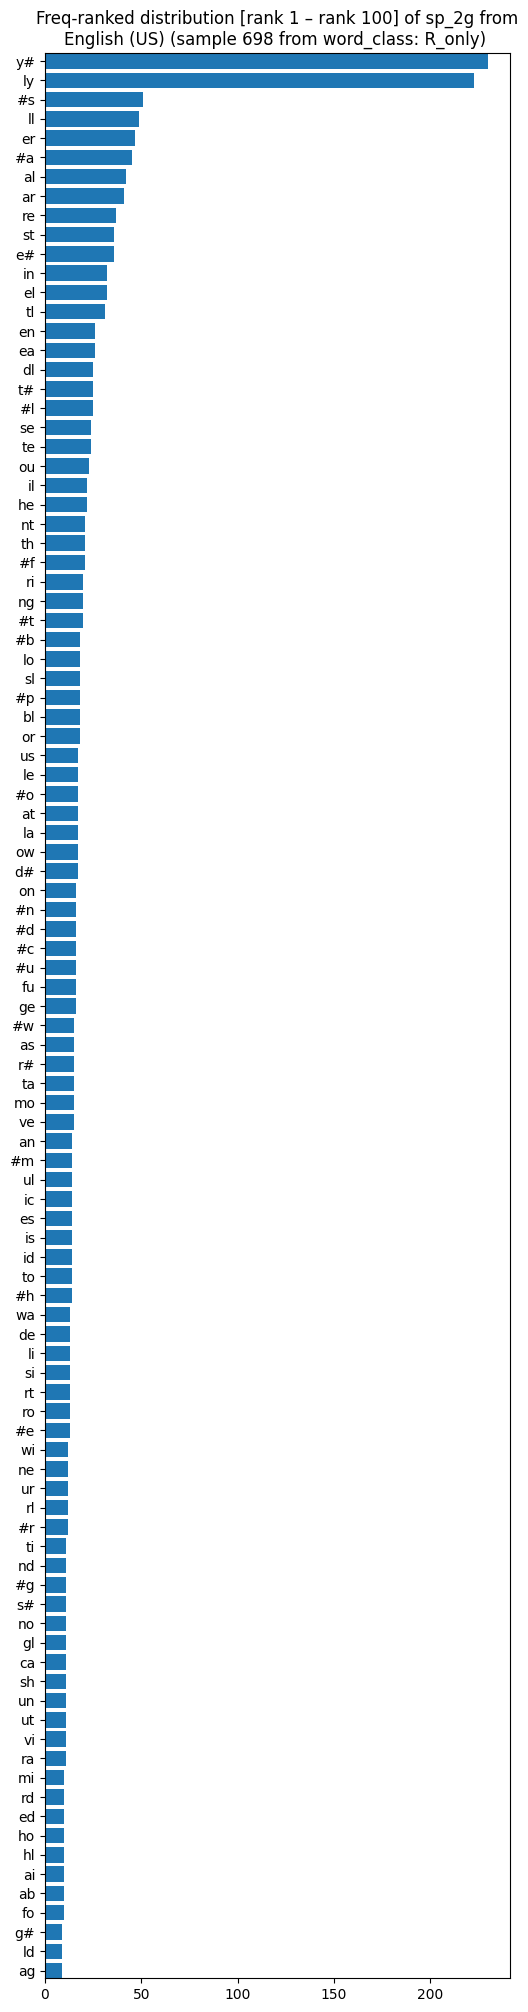

In [350]:
## frequency-ranked view
skippy = False
prefix = "sp_"
n_local = 2
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [351]:
## spell 3grams
add_ngram_to_df(df, n_for_ngram = 3, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_3gram
min_size: 1
supplement_var: sp_2gram
1049    [#sa, sav, ava, vag, age, gel, ely, ly#, #s, s...
411     [#ex, ext, xtr, tra, ra#, #e, ex, xt, tr, ra, ...
395     [#ev, eve, ver, erm, rmo, mor, ore, re#, #e, e...
540     [#he, hea, eav, avi, vil, ily, ly#, #h, he, ea...
1260    [#tw, two, wof, ofo, fol, old, ld#, #t, tw, wo...
                              ...                        
247     [#co, coo, ool, oll, lly, ly#, #c, co, oo, ol,...
1195    [#ta, tac, act, ctf, tfu, ful, ull, lly, ly#, ...
219        [#co, con, on#, #c, co, on, n#, #, c, o, n, #]
860     [#or, orn, rna, nat, ate, tel, ely, ly#, #o, o...
1098    [#sl, slo, low, owl, wly, ly#, #s, sl, lo, ow,...
Name: sp_3gram, Length: 386, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_24935/2238270198.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


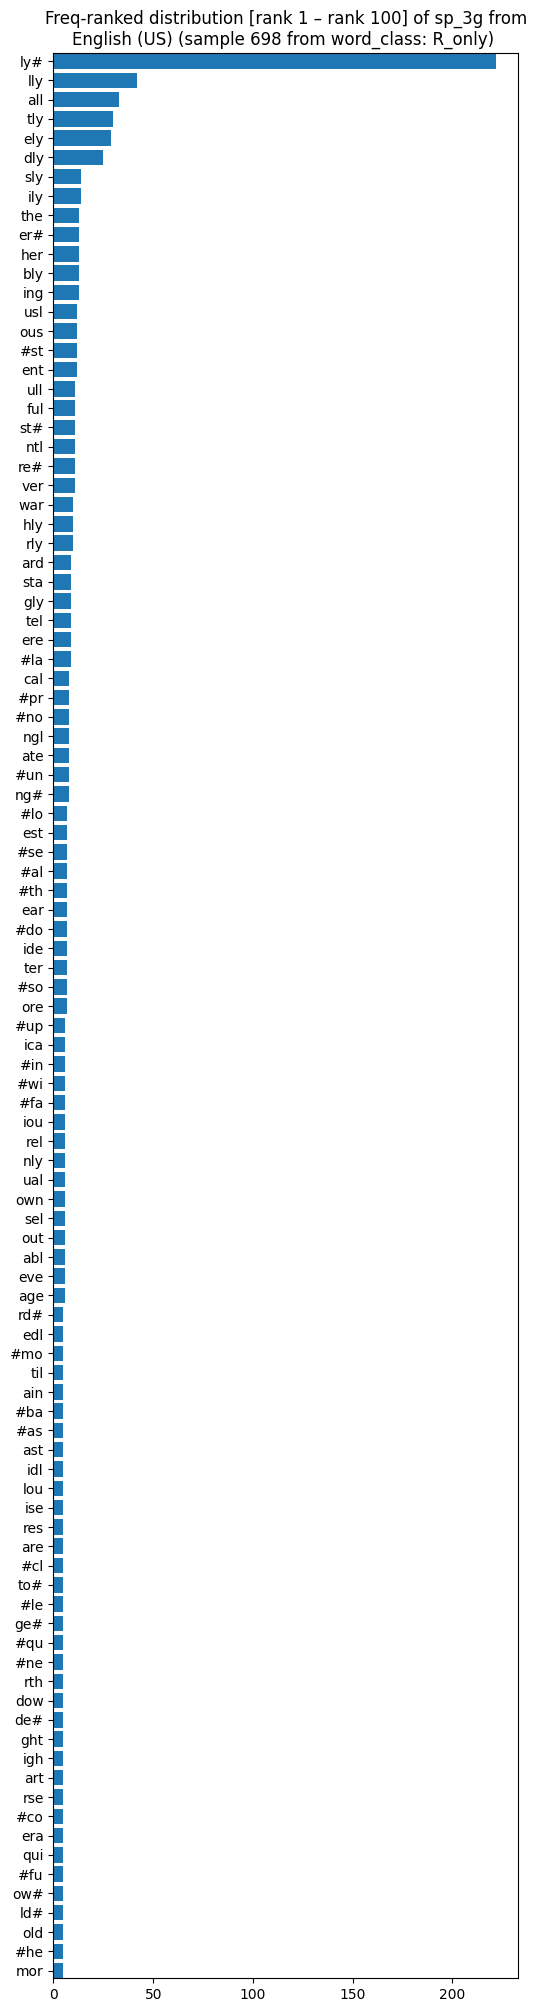

In [352]:
## frequency-ranke view
skippy = False
prefix = "sp_"
n_local = 3
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [353]:
## spell 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_4gram
min_size: 1
supplement_var: sp_3gram
1049    [#sav, sava, avag, vage, agel, gely, ely#, #sa...
411     [#ext, extr, xtra, tra#, #ex, ext, xtr, tra, r...
395     [#eve, ever, verm, ermo, rmor, more, ore#, #ev...
540     [#hea, heav, eavi, avil, vily, ily#, #he, hea,...
1260    [#two, twof, wofo, ofol, fold, old#, #tw, two,...
                              ...                        
247     [#coo, cool, ooll, olly, lly#, #co, coo, ool, ...
1195    [#tac, tact, actf, ctfu, tful, full, ully, lly...
219     [#con, con#, #co, con, on#, #c, co, on, n#, #,...
860     [#orn, orna, rnat, nate, atel, tely, ely#, #or...
1098    [#slo, slow, lowl, owly, wly#, #sl, slo, low, ...
Name: sp_4gram, Length: 386, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_24935/2238270198.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


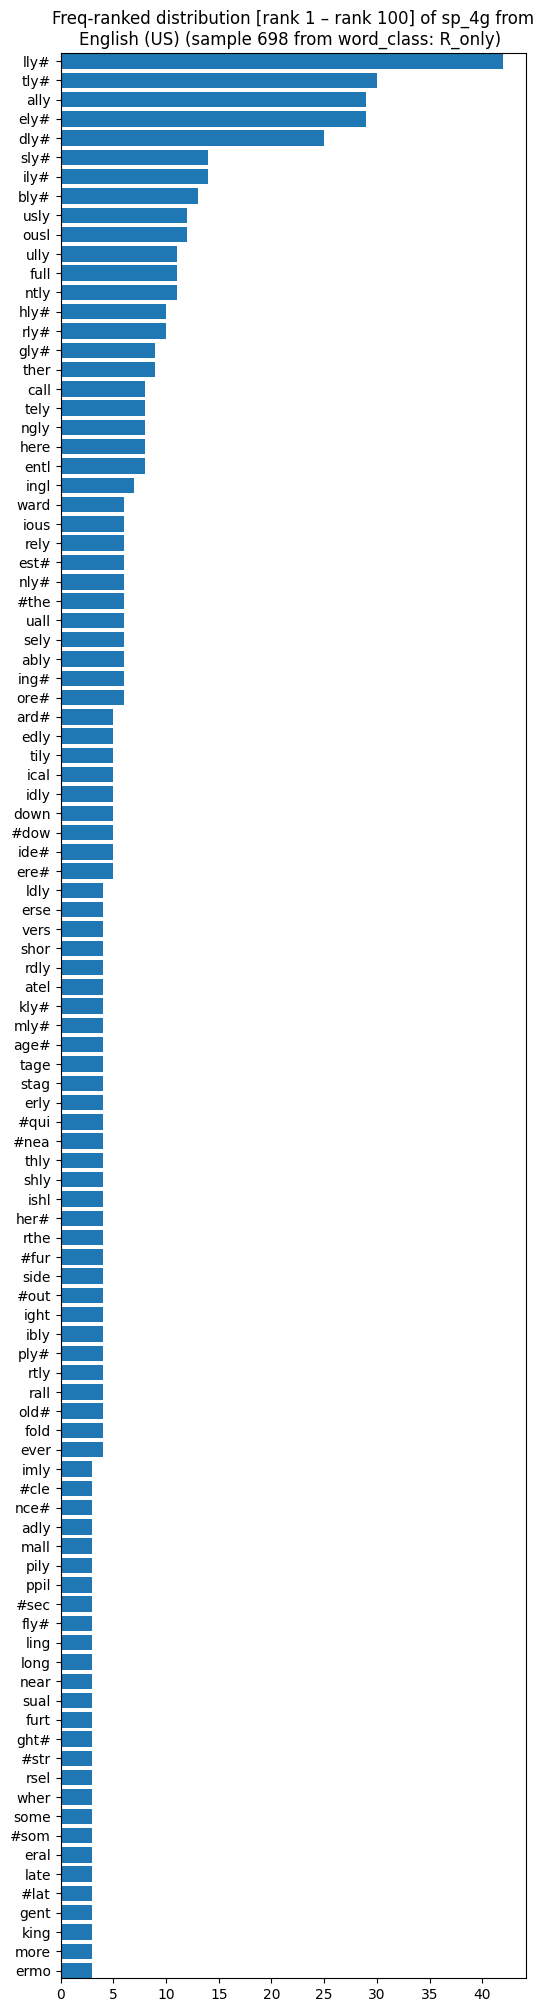

In [354]:
## frequency-ranke view
skippy = False
prefix = "sp_"
n_local = 4
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [355]:
## spell 5grams
add_ngram_to_df(df, n_for_ngram = 5, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_5gram
min_size: 1
supplement_var: sp_4gram
1049    [#sava, savag, avage, vagel, agely, gely#, #sa...
411     [#extr, extra, xtra#, #ext, extr, xtra, tra#, ...
395     [#ever, everm, vermo, ermor, rmore, more#, #ev...
540     [#heav, heavi, eavil, avily, vily#, #hea, heav...
1260    [#twof, twofo, wofol, ofold, fold#, #two, twof...
                              ...                        
247     [#cool, cooll, oolly, olly#, #coo, cool, ooll,...
1195    [#tact, tactf, actfu, ctful, tfull, fully, ull...
219     [#con#, #con, con#, #co, con, on#, #c, co, on,...
860     [#orna, ornat, rnate, natel, ately, tely#, #or...
1098    [#slow, slowl, lowly, owly#, #slo, slow, lowl,...
Name: sp_5gram, Length: 386, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_24935/2238270198.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


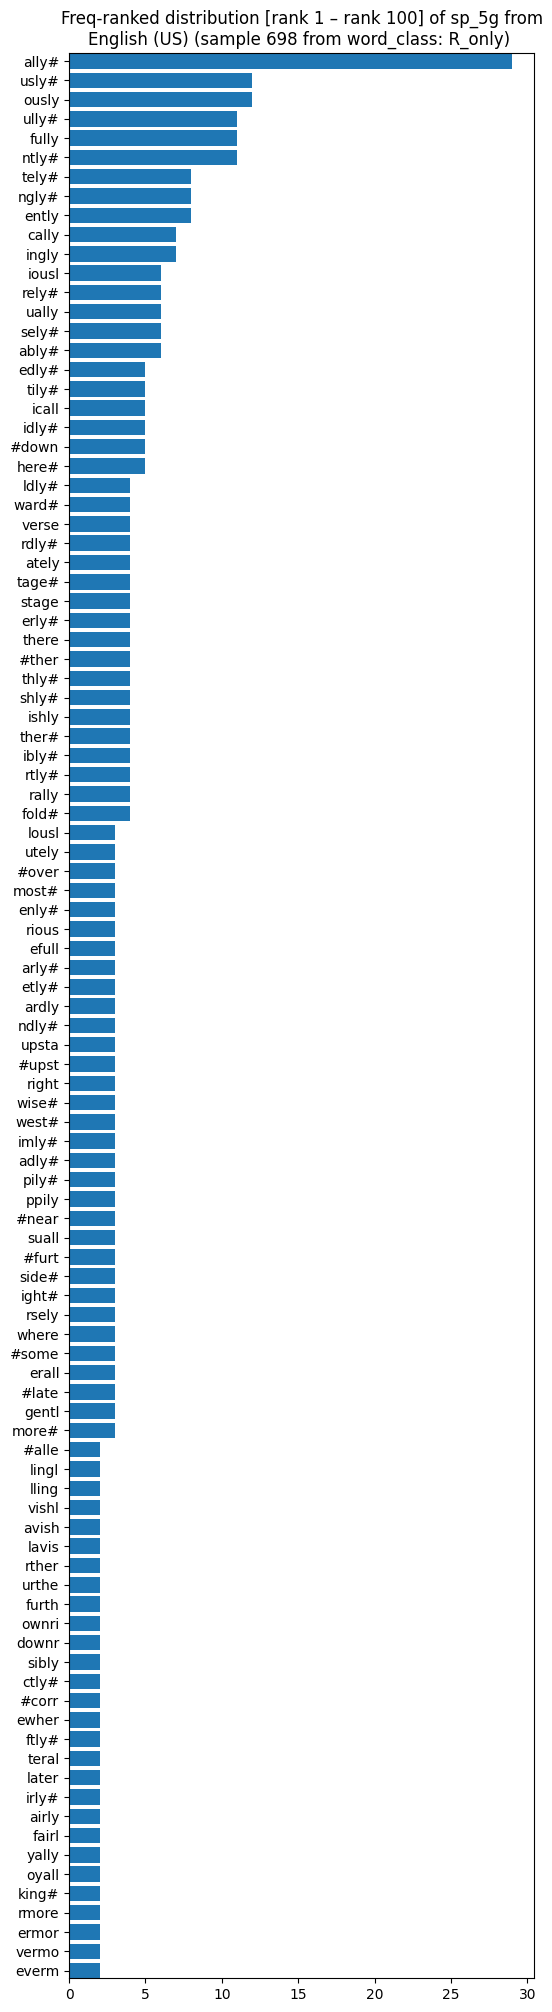

In [356]:
## frequency-rank view
skippy = False
prefix = "sp_"
n_local = 5
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

### skippy spell

In [357]:
## spell skippy 2grams
add_ngram_to_df(df, n_for_ngram = 2, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_sk2gram
min_size: 1
supplement_var: sp_1gram
1049    [#s, #…a, #…v, #…a, #…g, #…e, #…l, #…y, #…#, s...
411     [#e, #…x, #…t, #…r, #…a, #…#, ex, e…t, e…r, e…...
395     [#e, #…v, #…e, #…r, #…m, #…o, #…r, #…e, #…#, e...
540     [#h, #…e, #…a, #…v, #…i, #…l, #…y, #…#, he, h…...
1260    [#t, #…w, #…o, #…f, #…o, #…l, #…d, #…#, tw, t…...
                              ...                        
247     [#c, #…o, #…o, #…l, #…l, #…y, #…#, co, c…o, c…...
1195    [#t, #…a, #…c, #…t, #…f, #…u, #…l, #…l, #…y, #...
219     [#c, #…o, #…n, #…#, co, c…n, c…#, on, o…#, n#,...
860     [#o, #…r, #…n, #…a, #…t, #…e, #…l, #…y, #…#, o...
1098    [#s, #…l, #…o, #…w, #…l, #…y, #…#, sl, s…o, s…...
Name: sp_sk2gram, Length: 386, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_24935/2238270198.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


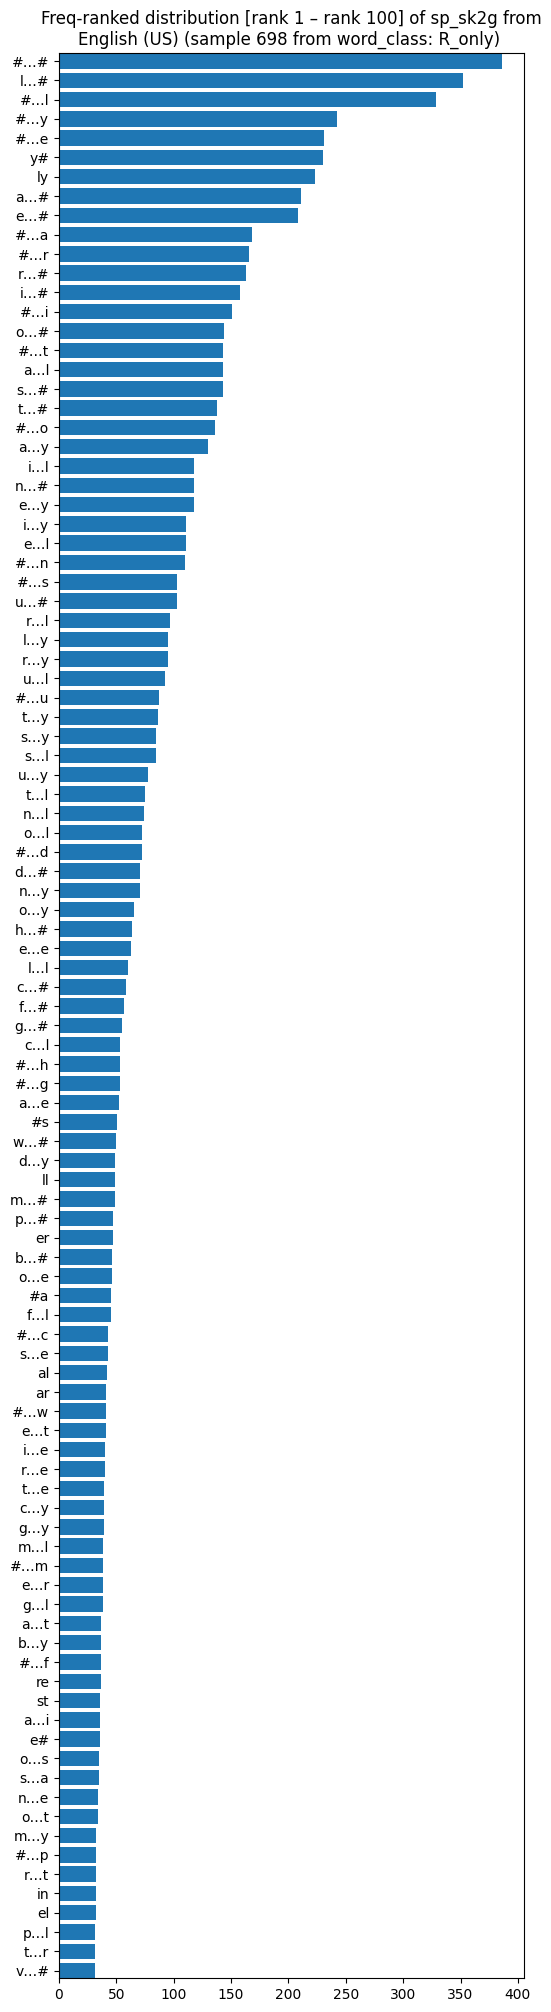

In [358]:
## frequency-ranked view
skippy = True
prefix = "sp_"
n_local = 2
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [359]:
## spell skippy 3grams
add_ngram_to_df(df, n_for_ngram = 3, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_sk3gram
min_size: 1
supplement_var: sp_sk2gram
1049    [#sa, #s…v, #s…a, #s…g, #s…e, #s…l, #s…y, #s…#...
411     [#ex, #e…t, #e…r, #e…a, #e…#, #…xt, #…x…r, #…x...
395     [#ev, #e…e, #e…r, #e…m, #e…o, #e…r, #e…e, #e…#...
540     [#he, #h…a, #h…v, #h…i, #h…l, #h…y, #h…#, #…ea...
1260    [#tw, #t…o, #t…f, #t…o, #t…l, #t…d, #t…#, #…wo...
                              ...                        
247     [#co, #c…o, #c…l, #c…l, #c…y, #c…#, #…oo, #…o…...
1195    [#ta, #t…c, #t…t, #t…f, #t…u, #t…l, #t…l, #t…y...
219     [#co, #c…n, #c…#, #…on, #…o…#, #…n#, con, co…#...
860     [#or, #o…n, #o…a, #o…t, #o…e, #o…l, #o…y, #o…#...
1098    [#sl, #s…o, #s…w, #s…l, #s…y, #s…#, #…lo, #…l…...
Name: sp_sk3gram, Length: 386, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_24935/2238270198.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


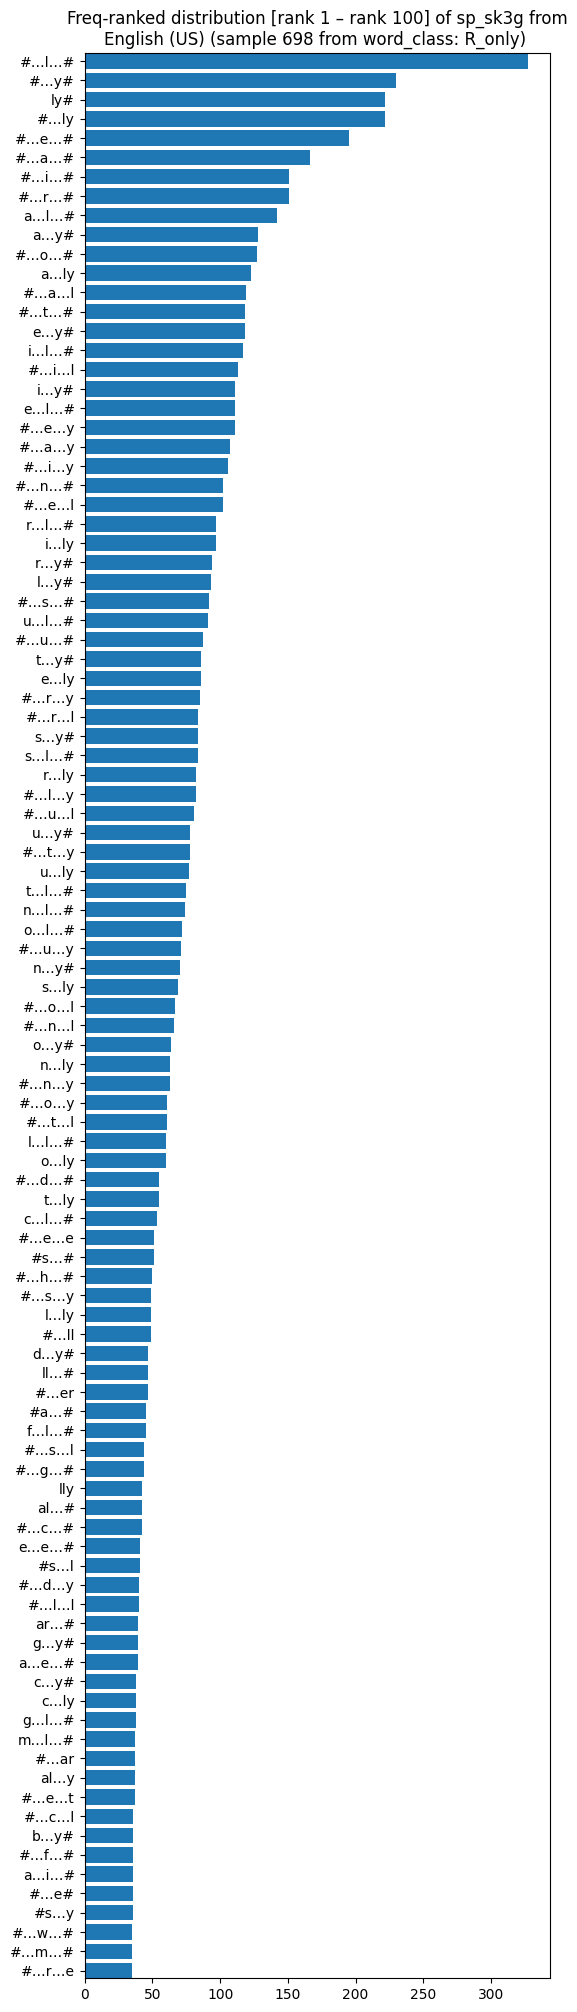

In [360]:
## frequency-ranked view
skippy = True
prefix = "sp_"
n_local = 3
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [361]:
## spell skippy 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_sk4gram
min_size: 1
supplement_var: sp_sk3gram
1049    [#sav, #sa…a, #sa…g, #sa…e, #sa…l, #sa…y, #sa…...
411     [#ext, #ex…r, #ex…a, #ex…#, #e…tr, #e…t…a, #e…...
395     [#eve, #ev…r, #ev…m, #ev…o, #ev…r, #ev…e, #ev…...
540     [#hea, #he…v, #he…i, #he…l, #he…y, #he…#, #h…a...
1260    [#two, #tw…f, #tw…o, #tw…l, #tw…d, #tw…#, #t…o...
                              ...                        
247     [#coo, #co…l, #co…l, #co…y, #co…#, #c…ol, #c…o...
1195    [#tac, #ta…t, #ta…f, #ta…u, #ta…l, #ta…l, #ta…...
219     [#con, #co…#, #c…n#, #…on#, con#, #co, #c…n, #...
860     [#orn, #or…a, #or…t, #or…e, #or…l, #or…y, #or…...
1098    [#slo, #sl…w, #sl…l, #sl…y, #sl…#, #s…ow, #s…o...
Name: sp_sk4gram, Length: 386, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_24935/2238270198.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


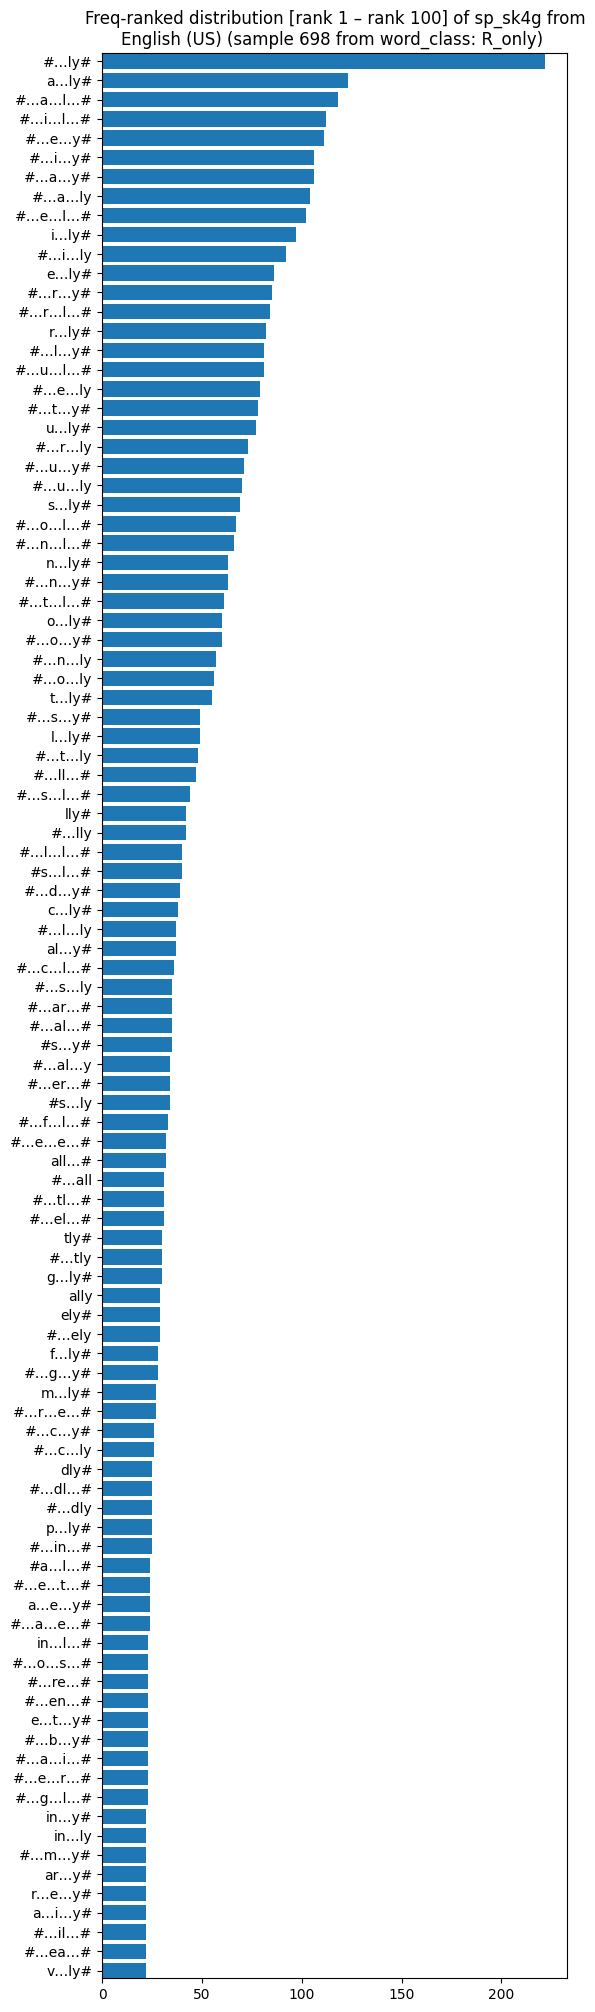

In [362]:
## frequency-ranked view
skippy = True
prefix = "sp_"
n_local = 4
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [363]:
## spell skippy 5grams
add_ngram_to_df(df, n_for_ngram = 5, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_sk5gram
min_size: 1
supplement_var: sp_sk4gram
1049    [#sava, #sav…g, #sav…e, #sav…l, #sav…y, #sav…#...
411     [#extr, #ext…a, #ext…#, #ex…ra, #ex…r…#, #ex…a...
395     [#ever, #eve…m, #eve…o, #eve…r, #eve…e, #eve…#...
540     [#heav, #hea…i, #hea…l, #hea…y, #hea…#, #he…vi...
1260    [#twof, #two…o, #two…l, #two…d, #two…#, #tw…fo...
                              ...                        
247     [#cool, #coo…l, #coo…y, #coo…#, #co…ll, #co…l…...
1195    [#tact, #tac…f, #tac…u, #tac…l, #tac…l, #tac…y...
219     [#con#, #con, #co…#, #c…n#, #…on#, con#, #co, ...
860     [#orna, #orn…t, #orn…e, #orn…l, #orn…y, #orn…#...
1098    [#slow, #slo…l, #slo…y, #slo…#, #sl…wl, #sl…w…...
Name: sp_sk5gram, Length: 386, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_24935/2238270198.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


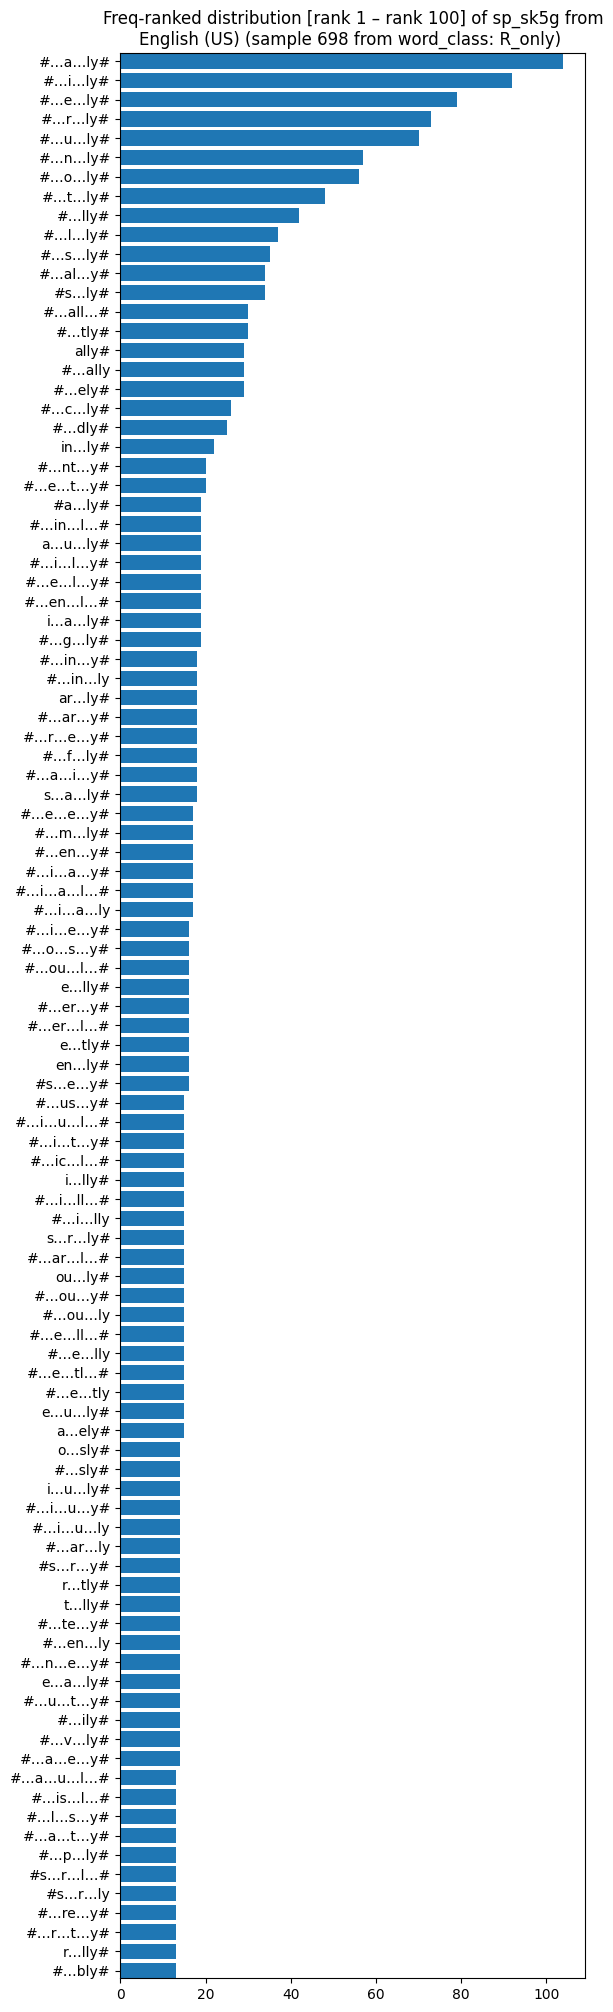

In [364]:
## frequency-ranked view
skippy = True
prefix = "sp_"
n_local = 5
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

## Sound

In [365]:
## stop for unimplemented language
if target_lang_name in [ 'Irish' ]:
    import sys
    sys.exit()

### Non-skippy sound

In [366]:
## sound 2grams
add_ngram_to_df(df, n_for_ngram = 2, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_2gram
min_size: 1
supplement_var: sn_1gram
1049    [#s, sæ, æv, vɪ, ɪd, dʒ, ʒɫ, ɫi, i#, #, s, æ, ...
411     [#ɛ, ɛk, ks, st, tɹ, ɹə, ə#, #, ɛ, k, s, t, ɹ,...
395     [#ɛ, ɛv, vɝ, ɝm, mɔ, ɔɹ, ɹ#, #, ɛ, v, ɝ, m, ɔ,...
540     [#h, hɛ, ɛv, və, əɫ, ɫi, i#, #, h, ɛ, v, ə, ɫ,...
1260    [#t, tu, uf, fo, oʊ, ʊɫ, ɫd, d#, #, t, u, f, o...
                              ...                        
247                [#k, ku, uɫ, ɫi, i#, #, k, u, ɫ, i, #]
1195    [#t, tæ, æk, kt, tf, fə, əɫ, ɫi, i#, #, t, æ, ...
219                       [#k, kɑ, ɑn, n#, #, k, ɑ, n, #]
860     [#ɔ, ɔɹ, ɹn, ne, eɪ, ɪt, tɫ, ɫi, i#, #, ɔ, ɹ, ...
1098    [#s, sɫ, ɫo, oʊ, ʊɫ, ɫi, i#, #, s, ɫ, o, ʊ, ɫ,...
Name: sn_2gram, Length: 386, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_24935/2238270198.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


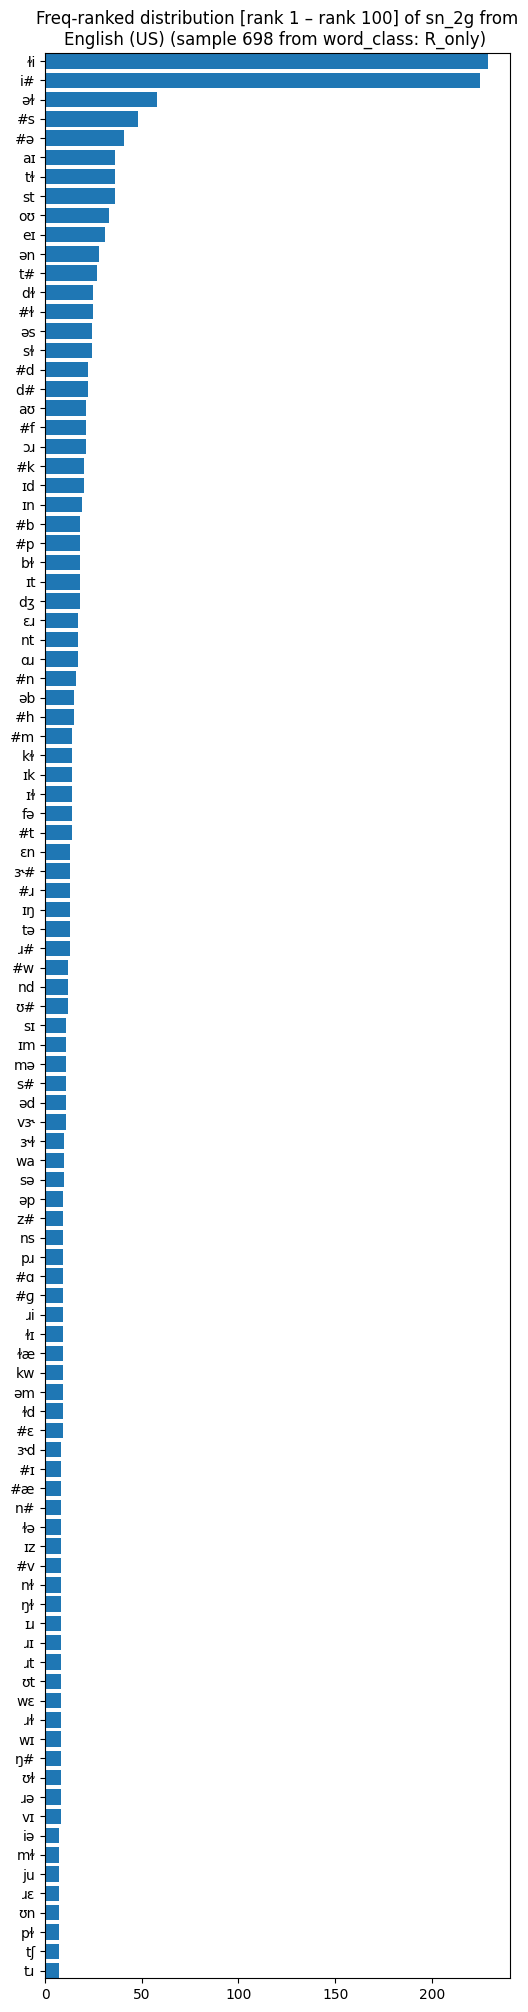

In [367]:
## frequency-ranked view
skippy = False
prefix = "sn_"
n_local = 2
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [368]:
## sound 3grams
add_ngram_to_df(df, n_for_ngram = 3, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_3gram
min_size: 1
supplement_var: sn_2gram
1049    [#sæ, sæv, ævɪ, vɪd, ɪdʒ, dʒɫ, ʒɫi, ɫi#, #s, s...
411     [#ɛk, ɛks, kst, stɹ, tɹə, ɹə#, #ɛ, ɛk, ks, st,...
395     [#ɛv, ɛvɝ, vɝm, ɝmɔ, mɔɹ, ɔɹ#, #ɛ, ɛv, vɝ, ɝm,...
540     [#hɛ, hɛv, ɛvə, vəɫ, əɫi, ɫi#, #h, hɛ, ɛv, və,...
1260    [#tu, tuf, ufo, foʊ, oʊɫ, ʊɫd, ɫd#, #t, tu, uf...
                              ...                        
247     [#ku, kuɫ, uɫi, ɫi#, #k, ku, uɫ, ɫi, i#, #, k,...
1195    [#tæ, tæk, ækt, ktf, tfə, fəɫ, əɫi, ɫi#, #t, t...
219        [#kɑ, kɑn, ɑn#, #k, kɑ, ɑn, n#, #, k, ɑ, n, #]
860     [#ɔɹ, ɔɹn, ɹne, neɪ, eɪt, ɪtɫ, tɫi, ɫi#, #ɔ, ɔ...
1098    [#sɫ, sɫo, ɫoʊ, oʊɫ, ʊɫi, ɫi#, #s, sɫ, ɫo, oʊ,...
Name: sn_3gram, Length: 386, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_24935/2238270198.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


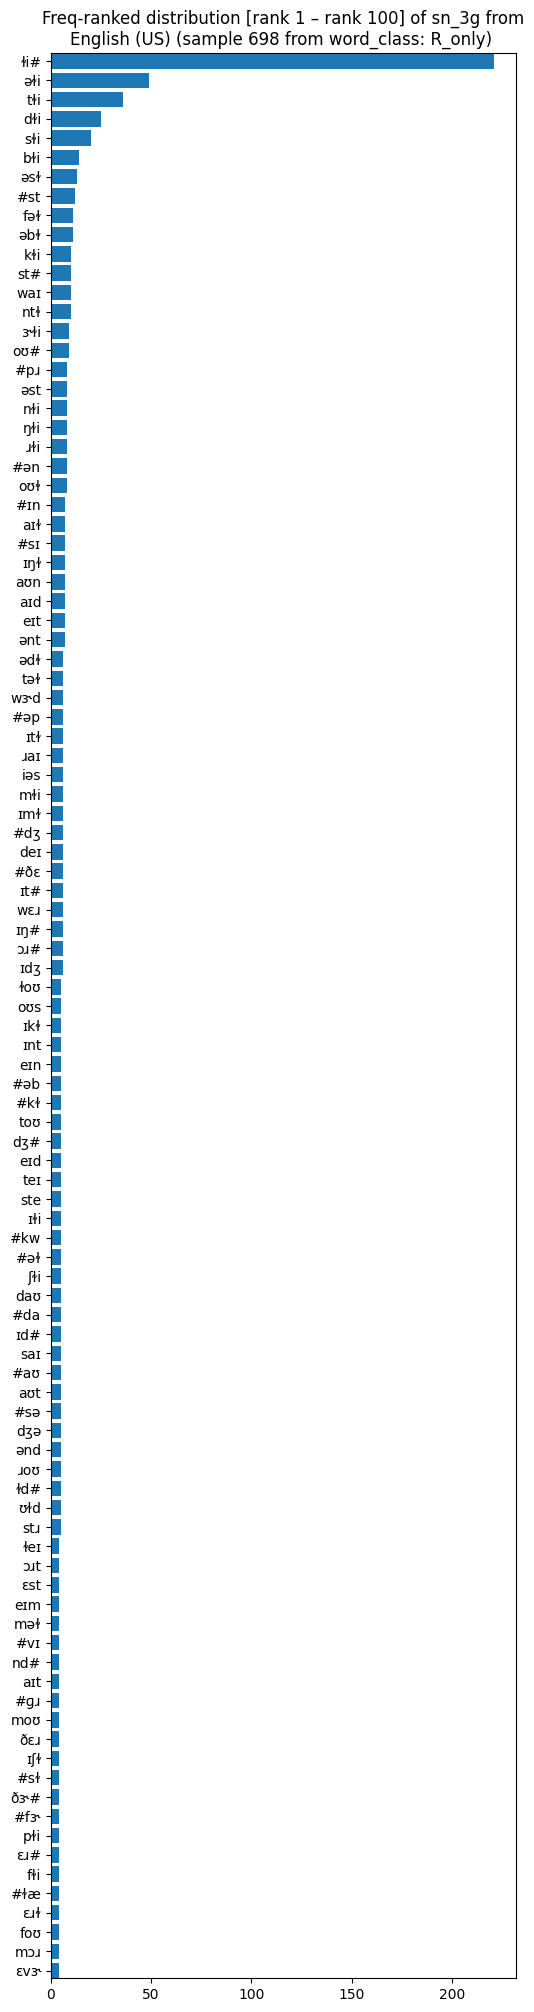

In [369]:
## frequency-ranked view
skippy = False
prefix = "sn_"
n_local = 3
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [370]:
## sound 4grams
add_ngram_to_df(df, n_for_ngram = 4, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_4gram
min_size: 1
supplement_var: sn_3gram
1049    [#sæv, sævɪ, ævɪd, vɪdʒ, ɪdʒɫ, dʒɫi, ʒɫi#, #sæ...
411     [#ɛks, ɛkst, kstɹ, stɹə, tɹə#, #ɛk, ɛks, kst, ...
395     [#ɛvɝ, ɛvɝm, vɝmɔ, ɝmɔɹ, mɔɹ#, #ɛv, ɛvɝ, vɝm, ...
540     [#hɛv, hɛvə, ɛvəɫ, vəɫi, əɫi#, #hɛ, hɛv, ɛvə, ...
1260    [#tuf, tufo, ufoʊ, foʊɫ, oʊɫd, ʊɫd#, #tu, tuf,...
                              ...                        
247     [#kuɫ, kuɫi, uɫi#, #ku, kuɫ, uɫi, ɫi#, #k, ku,...
1195    [#tæk, tækt, æktf, ktfə, tfəɫ, fəɫi, əɫi#, #tæ...
219     [#kɑn, kɑn#, #kɑ, kɑn, ɑn#, #k, kɑ, ɑn, n#, #,...
860     [#ɔɹn, ɔɹne, ɹneɪ, neɪt, eɪtɫ, ɪtɫi, tɫi#, #ɔɹ...
1098    [#sɫo, sɫoʊ, ɫoʊɫ, oʊɫi, ʊɫi#, #sɫ, sɫo, ɫoʊ, ...
Name: sn_4gram, Length: 386, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_24935/2238270198.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


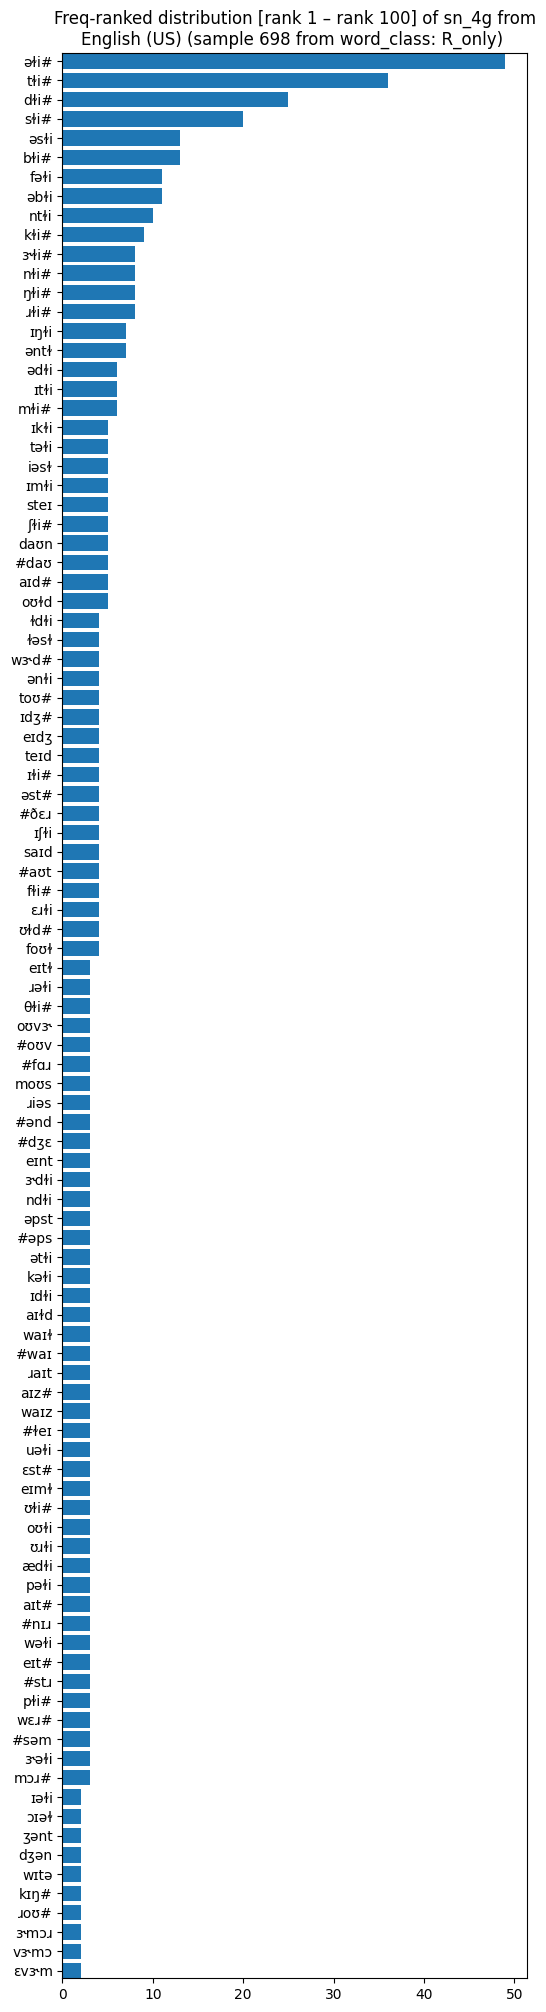

In [371]:
## frequency-ranked view
skippy = False
prefix = "sn_"
n_local = 4
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [372]:
## sound 5grams
add_ngram_to_df(df, n_for_ngram = 5, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_5gram
min_size: 1
supplement_var: sn_4gram
1049    [#sævɪ, sævɪd, ævɪdʒ, vɪdʒɫ, ɪdʒɫi, dʒɫi#, #sæ...
411     [#ɛkst, ɛkstɹ, kstɹə, stɹə#, #ɛks, ɛkst, kstɹ,...
395     [#ɛvɝm, ɛvɝmɔ, vɝmɔɹ, ɝmɔɹ#, #ɛvɝ, ɛvɝm, vɝmɔ,...
540     [#hɛvə, hɛvəɫ, ɛvəɫi, vəɫi#, #hɛv, hɛvə, ɛvəɫ,...
1260    [#tufo, tufoʊ, ufoʊɫ, foʊɫd, oʊɫd#, #tuf, tufo...
                              ...                        
247     [#kuɫi, kuɫi#, #kuɫ, kuɫi, uɫi#, #ku, kuɫ, uɫi...
1195    [#tækt, tæktf, æktfə, ktfəɫ, tfəɫi, fəɫi#, #tæ...
219     [#kɑn#, #kɑn, kɑn#, #kɑ, kɑn, ɑn#, #k, kɑ, ɑn,...
860     [#ɔɹne, ɔɹneɪ, ɹneɪt, neɪtɫ, eɪtɫi, ɪtɫi#, #ɔɹ...
1098    [#sɫoʊ, sɫoʊɫ, ɫoʊɫi, oʊɫi#, #sɫo, sɫoʊ, ɫoʊɫ,...
Name: sn_5gram, Length: 386, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_24935/2238270198.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


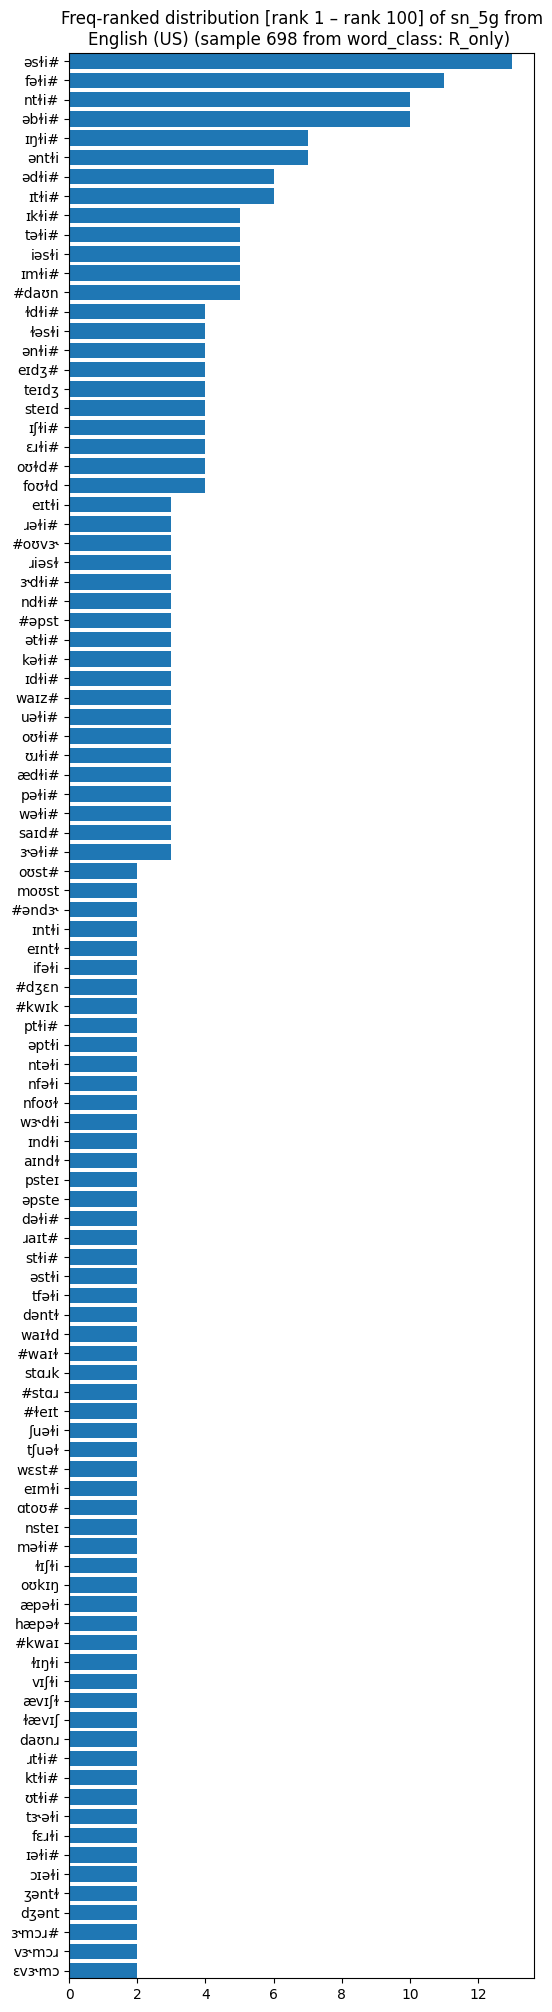

In [373]:
## frequency-ranked view
skippy = False
prefix = "sn_"
n_local = 5
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

### skippy sound

In [374]:
## sound skippy 2grams
add_ngram_to_df(df, n_for_ngram = 2, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_sk2gram
min_size: 1
supplement_var: sn_1gram
1049    [#s, #…æ, #…v, #…ɪ, #…d, #…ʒ, #…ɫ, #…i, #…#, s...
411     [#ɛ, #…k, #…s, #…t, #…ɹ, #…ə, #…#, ɛk, ɛ…s, ɛ…...
395     [#ɛ, #…v, #…ɝ, #…m, #…ɔ, #…ɹ, #…#, ɛv, ɛ…ɝ, ɛ…...
540     [#h, #…ɛ, #…v, #…ə, #…ɫ, #…i, #…#, hɛ, h…v, h…...
1260    [#t, #…u, #…f, #…o, #…ʊ, #…ɫ, #…d, #…#, tu, t…...
                              ...                        
247     [#k, #…u, #…ɫ, #…i, #…#, ku, k…ɫ, k…i, k…#, uɫ...
1195    [#t, #…æ, #…k, #…t, #…f, #…ə, #…ɫ, #…i, #…#, t...
219     [#k, #…ɑ, #…n, #…#, kɑ, k…n, k…#, ɑn, ɑ…#, n#,...
860     [#ɔ, #…ɹ, #…n, #…e, #…ɪ, #…t, #…ɫ, #…i, #…#, ɔ...
1098    [#s, #…ɫ, #…o, #…ʊ, #…ɫ, #…i, #…#, sɫ, s…o, s…...
Name: sn_sk2gram, Length: 386, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_24935/2238270198.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


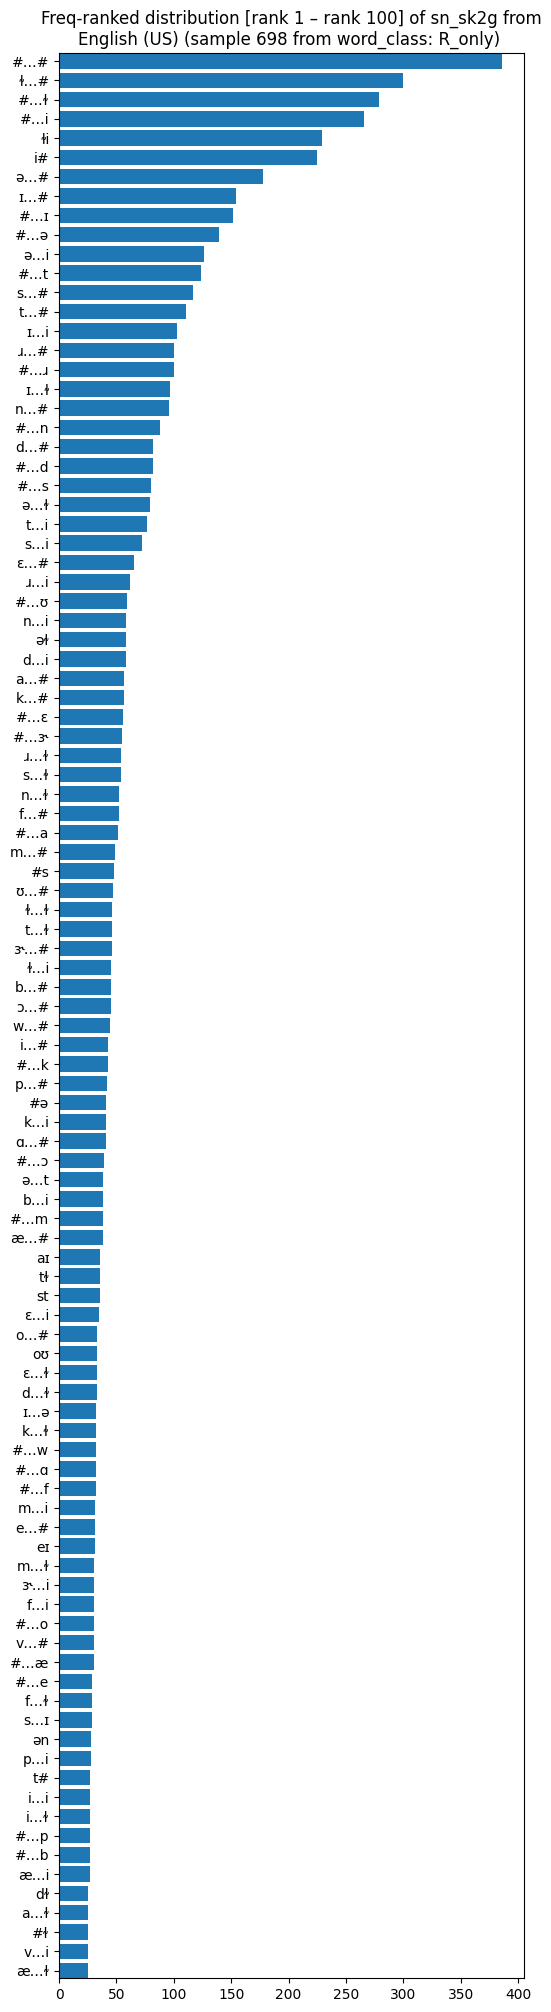

In [375]:
## frequency-ranked view
skippy = True
prefix = "sn_"
n_local = 2
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [376]:
## sound skippy 3grams
add_ngram_to_df(df, n_for_ngram = 3, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_sk3gram
min_size: 1
supplement_var: sn_sk2gram
1049    [#sæ, #s…v, #s…ɪ, #s…d, #s…ʒ, #s…ɫ, #s…i, #s…#...
411     [#ɛk, #ɛ…s, #ɛ…t, #ɛ…ɹ, #ɛ…ə, #ɛ…#, #…ks, #…k…...
395     [#ɛv, #ɛ…ɝ, #ɛ…m, #ɛ…ɔ, #ɛ…ɹ, #ɛ…#, #…vɝ, #…v…...
540     [#hɛ, #h…v, #h…ə, #h…ɫ, #h…i, #h…#, #…ɛv, #…ɛ…...
1260    [#tu, #t…f, #t…o, #t…ʊ, #t…ɫ, #t…d, #t…#, #…uf...
                              ...                        
247     [#ku, #k…ɫ, #k…i, #k…#, #…uɫ, #…u…i, #…u…#, #…...
1195    [#tæ, #t…k, #t…t, #t…f, #t…ə, #t…ɫ, #t…i, #t…#...
219     [#kɑ, #k…n, #k…#, #…ɑn, #…ɑ…#, #…n#, kɑn, kɑ…#...
860     [#ɔɹ, #ɔ…n, #ɔ…e, #ɔ…ɪ, #ɔ…t, #ɔ…ɫ, #ɔ…i, #ɔ…#...
1098    [#sɫ, #s…o, #s…ʊ, #s…ɫ, #s…i, #s…#, #…ɫo, #…ɫ…...
Name: sn_sk3gram, Length: 386, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_24935/2238270198.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


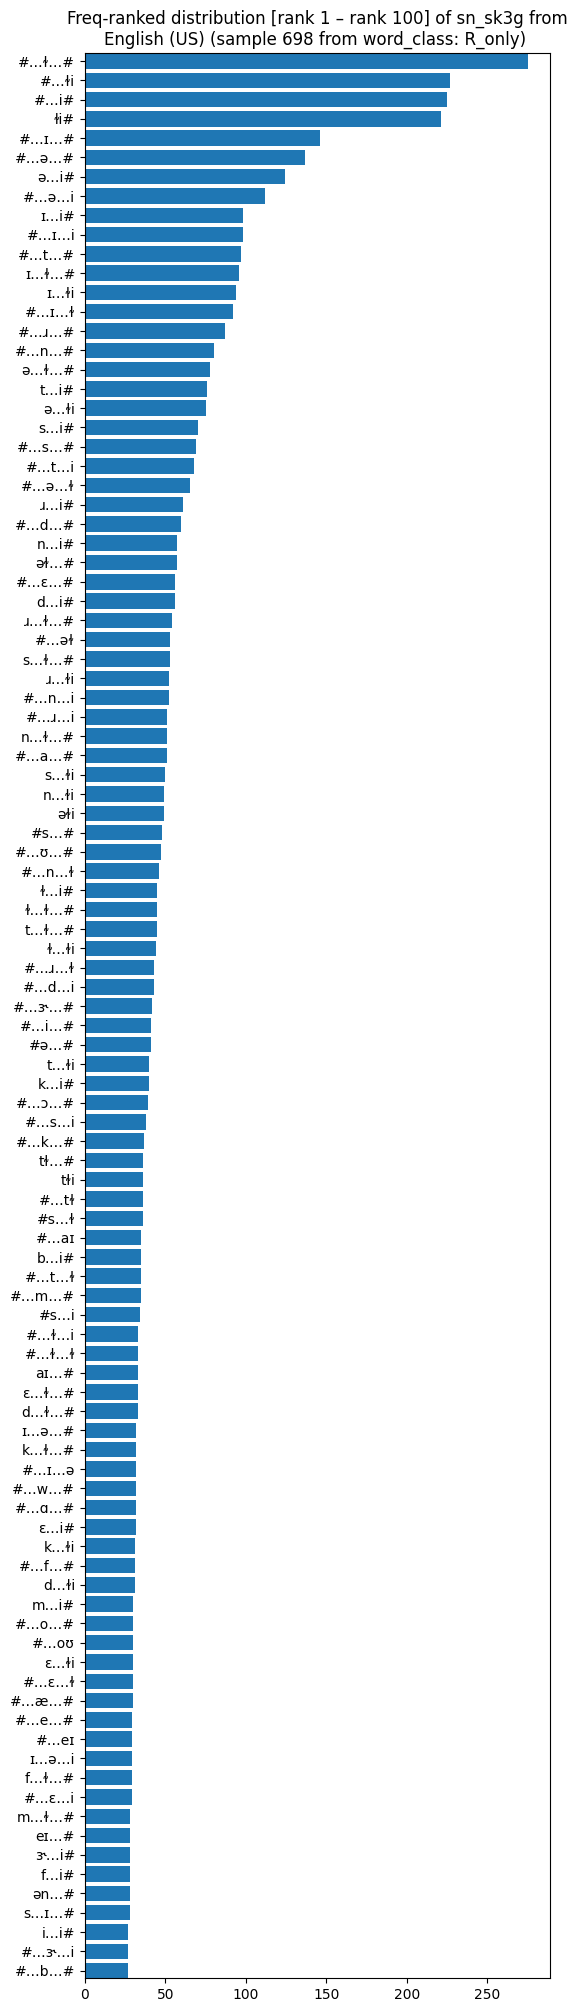

In [377]:
## frequency-ranked view
skippy = True
prefix = "sn_"
n_local = 3
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [378]:
## sound skippy 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sn_", skippy = True, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_sk4gram
min_size: 1
supplement_var: sn_sk3gram
1049    [#sæv, #sæ…ɪ, #sæ…d, #sæ…ʒ, #sæ…ɫ, #sæ…i, #sæ…...
411     [#ɛks, #ɛk…t, #ɛk…ɹ, #ɛk…ə, #ɛk…#, #ɛ…st, #ɛ…s...
395     [#ɛvɝ, #ɛv…m, #ɛv…ɔ, #ɛv…ɹ, #ɛv…#, #ɛ…ɝm, #ɛ…ɝ...
540     [#hɛv, #hɛ…ə, #hɛ…ɫ, #hɛ…i, #hɛ…#, #h…və, #h…v...
1260    [#tuf, #tu…o, #tu…ʊ, #tu…ɫ, #tu…d, #tu…#, #t…f...
                              ...                        
247     [#kuɫ, #ku…i, #ku…#, #k…ɫi, #k…ɫ…#, #k…i#, #…u...
1195    [#tæk, #tæ…t, #tæ…f, #tæ…ə, #tæ…ɫ, #tæ…i, #tæ…...
219     [#kɑn, #kɑ…#, #k…n#, #…ɑn#, kɑn#, #kɑ, #k…n, #...
860     [#ɔɹn, #ɔɹ…e, #ɔɹ…ɪ, #ɔɹ…t, #ɔɹ…ɫ, #ɔɹ…i, #ɔɹ…...
1098    [#sɫo, #sɫ…ʊ, #sɫ…ɫ, #sɫ…i, #sɫ…#, #s…oʊ, #s…o...
Name: sn_sk4gram, Length: 386, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_24935/2238270198.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


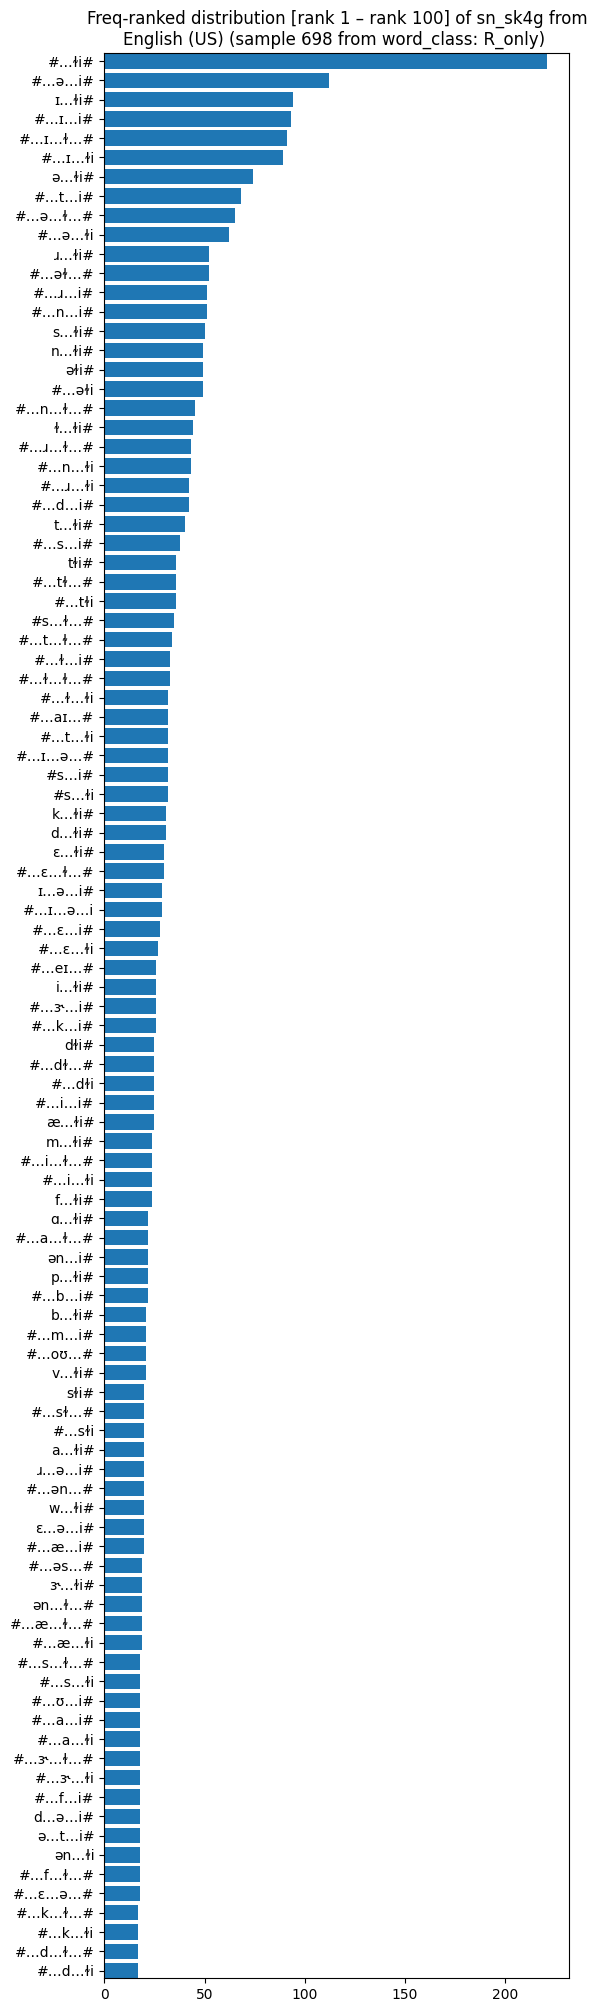

In [379]:
## frequency-ranked view
skippy = True
prefix = "sn_"
n_local = 4
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [380]:
## sound skippy 5grams
add_ngram_to_df(df, n_for_ngram = 5, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_sk5gram
min_size: 1
supplement_var: sn_sk4gram
1049    [#sævɪ, #sæv…d, #sæv…ʒ, #sæv…ɫ, #sæv…i, #sæv…#...
411     [#ɛkst, #ɛks…ɹ, #ɛks…ə, #ɛks…#, #ɛk…tɹ, #ɛk…t…...
395     [#ɛvɝm, #ɛvɝ…ɔ, #ɛvɝ…ɹ, #ɛvɝ…#, #ɛv…mɔ, #ɛv…m…...
540     [#hɛvə, #hɛv…ɫ, #hɛv…i, #hɛv…#, #hɛ…əɫ, #hɛ…ə…...
1260    [#tufo, #tuf…ʊ, #tuf…ɫ, #tuf…d, #tuf…#, #tu…oʊ...
                              ...                        
247     [#kuɫi, #kuɫ…#, #ku…i#, #k…ɫi#, #…uɫi#, kuɫi#,...
1195    [#tækt, #tæk…f, #tæk…ə, #tæk…ɫ, #tæk…i, #tæk…#...
219     [#kɑn#, #kɑn, #kɑ…#, #k…n#, #…ɑn#, kɑn#, #kɑ, ...
860     [#ɔɹne, #ɔɹn…ɪ, #ɔɹn…t, #ɔɹn…ɫ, #ɔɹn…i, #ɔɹn…#...
1098    [#sɫoʊ, #sɫo…ɫ, #sɫo…i, #sɫo…#, #sɫ…ʊɫ, #sɫ…ʊ…...
Name: sn_sk5gram, Length: 386, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_24935/2238270198.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


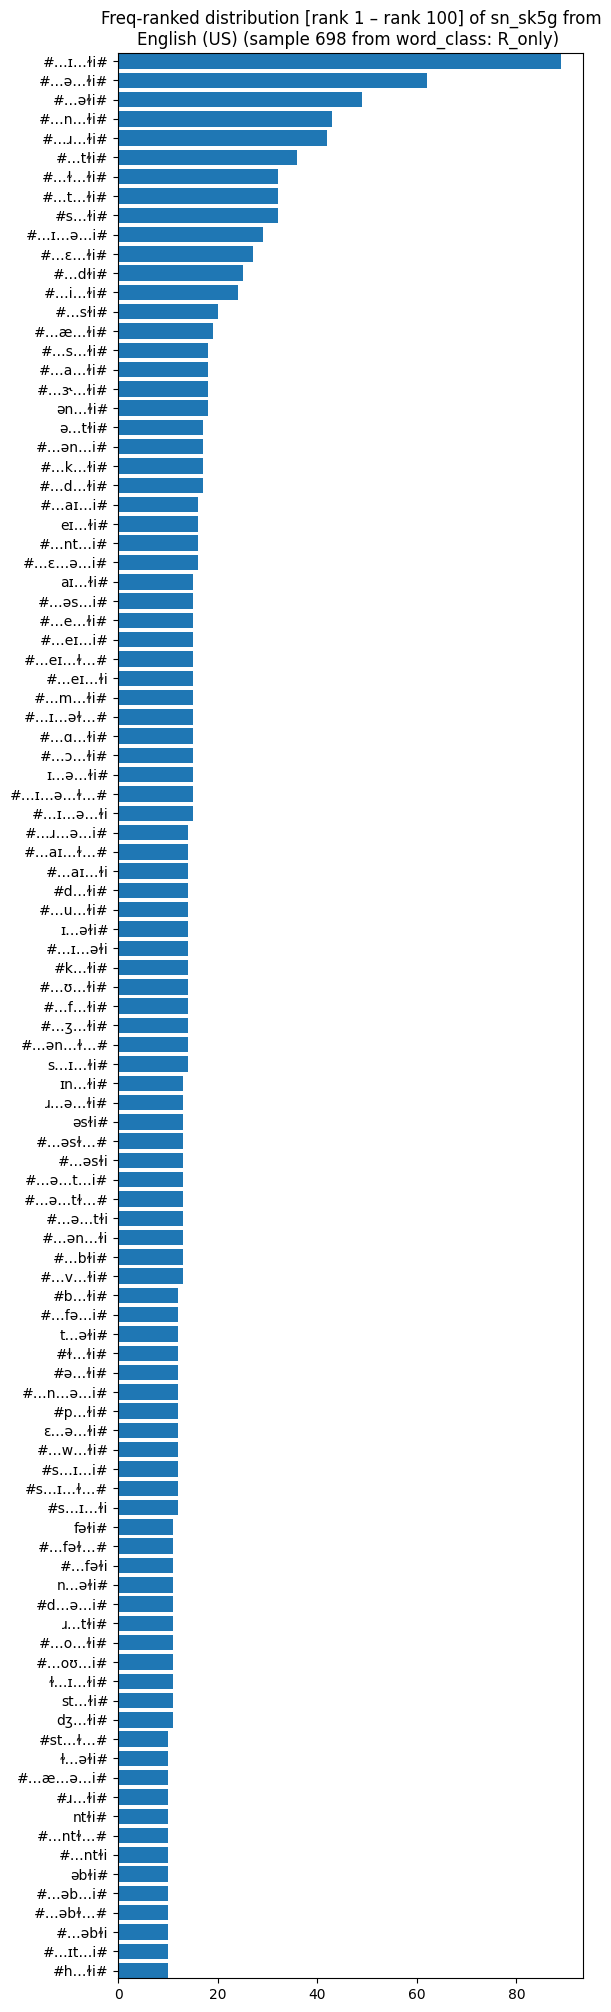

In [381]:
## frequency-ranked view
skippy = True
prefix = "sn_"
n_local = 5
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

# End